##### Importing packages

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import path, getcwd, chdir
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import path, getcwd, chdir
from IPython.display import clear_output
import sys
import random
import numpy as np
import pandas as pd
import cv2
import os
import copy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, Conv2D, Conv2DTranspose, MaxPooling2D, Softmax
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Sample_E2E_Manual8.zip -d Sample_E2E1

clear_output()

##### Preparing Data
Split Data manually into training, validation and test set with corresponding Masks

In [ ]:
# Locations for Testing and training images and masks
TestIrisDir= '/content/Sample_E2E1/Sample_E2E_Manual8/Test/RawIris'
TrainIrisDir='/content/Sample_E2E1/Sample_E2E_Manual8/Train/RawIris'
ValidIrisDir='/content/Sample_E2E1/Sample_E2E_Manual8/Validation/RawIris'

TestMasksDir='/content/Sample_E2E1/Sample_E2E_Manual8/Test/Masks'
TrainMasksDir='/content/Sample_E2E1/Sample_E2E_Manual8/Train/Mask'
ValidMasksDir='/content/Sample_E2E1/Sample_E2E_Manual8/Validation/Masks'


AugmnetationIrisDir='/content/Sample_E2E1/Sample_E2E_Manual8/Augmentation/RawIris'
AugmentationMaskDir='/content/Sample_E2E1/Sample_E2E_Manual8/Augmentation/Masks'


In [ ]:
#Generated train augmented images

seed = 42

Input_size=(256,256)
data_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     rescale=1./255)# Implement interpolation based Image padding function
Train_Image_datagen = ImageDataGenerator(**data_gen_args)
Train_Mask_datagen = ImageDataGenerator(**data_gen_args)


Train_Image_generator = Train_Image_datagen.flow_from_directory(TrainIrisDir,target_size=Input_size, color_mode='grayscale', batch_size=8, class_mode=None, seed=seed,save_to_dir=AugmnetationIrisDir, save_prefix='AG', save_format='png',)
Train_Mask_generator = Train_Mask_datagen.flow_from_directory(TrainMasksDir,target_size=Input_size, color_mode='grayscale', batch_size=8, class_mode=None, seed=seed,save_to_dir=AugmentationMaskDir, save_prefix='AG', save_format='png',)



In [ ]:
Test_Seed = 42
Test_Image_Datagen=ImageDataGenerator(rescale=1./255)
Test_Mask_Datagen=ImageDataGenerator(rescale=1./255)

Test_Image_generator = Test_Image_Datagen.flow_from_directory(TestIrisDir,target_size=Input_size, color_mode='grayscale', batch_size=1, class_mode=None, seed=Test_Seed, shuffle=False)
Test_Mask_generator = Test_Mask_Datagen.flow_from_directory(TestMasksDir,target_size=Input_size, color_mode='grayscale', batch_size=1, class_mode=None, seed=Test_Seed, shuffle=False)


In [ ]:
Validation_Seed=42
Validation_Image_Datagen=ImageDataGenerator(rescale=1./255)
Validation_Mask_Datagen=ImageDataGenerator(rescale=1./255)


Validation_Image_generator = Validation_Image_Datagen.flow_from_directory(ValidIrisDir,target_size=Input_size, color_mode='grayscale', batch_size=8, class_mode=None, seed=Validation_Seed,shuffle=False)
Validation_Mask_generator = Validation_Mask_Datagen.flow_from_directory(ValidMasksDir,target_size=Input_size, color_mode='grayscale', batch_size=8, class_mode=None, seed=Validation_Seed,shuffle=False)


In [ ]:
Train_Generator=(pair for pair in zip(Train_Image_generator,Train_Mask_generator))
Validation_Generator=(pair for pair in zip(Validation_Image_generator,Validation_Mask_generator))
Test_Generator=(pair for pair in zip(Test_Image_generator,Test_Mask_generator))

#### Data Visulization

In [ ]:
# DISPLAY AUGMENTED SAMPLES
def plotImages(images_arr, mask_arr, n):
    title = 'Augmeted Iris'
    TitleMask = 'Augmeted Masks'
    plt.figure(figsize=(15, 5))
    #axes = axes.flatten()
    for i in  range(len(images_arr)):
        plt.subplot(2,len(images_arr), i+1)
        plt.title(title)
        im=images_arr[i]
        image=im.reshape((im.shape[0],im.shape[1]))
        plt.imshow(image, cmap='gray')

    for i in  range(len(mask_arr)):
        plt.subplot(2,len(mask_arr), i+1+n)
        plt.title(TitleMask )
        im=mask_arr[i]
        image=im.reshape((im.shape[0],im.shape[1]))
        plt.imshow(image, cmap='gray')
    plt.tight_layout()
    plt.show()



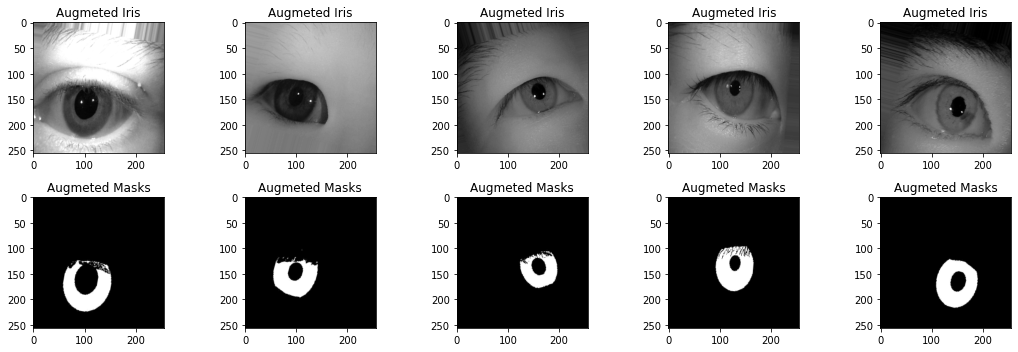

In [ ]:
n=5 # No of augmented samples for visualization
TIG, TMG =next(Train_Generator)
plotImages(TIG[0:n],TMG[0:n],n)

In [ ]:
# Image Dimension
print('Height:', TIG[0].shape[0])
print('Width:', TIG[0].shape[1])
image_size1=TIG[0].shape[0]
image_size2=TIG[0].shape[1]

Height: 256
Width: 256


In [ ]:
# def unet_plus_plus(base_filter_num=64,n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
def unet_plus_plus(base_filter_num=64, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
    conv0_0 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(s)
    conv0_0 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_0)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv0_0)

    conv1_0 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv1_0 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_0)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv1_0)

    up1_0 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_0)
    merge00_10 = concatenate([conv0_0,up1_0], axis=-1)
    conv0_1 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge00_10)
    conv0_1 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_1)

    conv2_0 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv2_0 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_0)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv2_0)

    up2_0 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_0)
    merge10_20 = concatenate([conv1_0,up2_0], axis=-1)
    conv1_1 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10_20)
    conv1_1 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)

    up1_1 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_1)
    merge01_11 = concatenate([conv0_0,conv0_1,up1_1], axis=-1)
    conv0_2 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge01_11)
    conv0_2 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_2)

    conv3_0 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv3_0 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_0)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3_0)

    up3_0 = Conv2DTranspose(base_filter_num*4, (2, 2), strides=(2, 2), padding='same')(conv3_0)
    merge20_30 = concatenate([conv2_0,up3_0], axis=-1)
    conv2_1 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge20_30)
    conv2_1 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)

    up2_1 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_1)
    merge11_21 = concatenate([conv1_0,conv1_1,up2_1], axis=-1)
    conv1_2 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11_21)
    conv1_2 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_2)

    up1_2 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_2)
    merge02_12 = concatenate([conv0_0,conv0_1,conv0_2,up1_2], axis=-1)
    conv0_3 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge02_12)
    conv0_3 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_3)

    conv4_0 = Conv2D(base_filter_num*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv4_0 = Conv2D(base_filter_num*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_0)

    up4_0 = Conv2DTranspose(base_filter_num*8, (2, 2), strides=(2, 2), padding='same')(conv4_0)
    merge30_40 = concatenate([conv3_0,up4_0], axis = -1)
    conv3_1 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge30_40)
    conv3_1 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)

    up3_1 = Conv2DTranspose(base_filter_num*4, (2, 2), strides=(2, 2), padding='same')(conv3_1)
    merge21_31 = concatenate([conv2_0,conv2_1,up3_1], axis = -1)
    conv2_2 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge21_31)
    conv2_2 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_2)

    up2_2 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_2)
    merge12_22 = concatenate([conv1_0,conv1_1,conv1_2,up2_2], axis = -1)
    conv1_3 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge12_22)
    conv1_3 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_3)

    up1_3 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_3)
    merge03_13 = concatenate([conv0_0,conv0_1,conv0_2,conv0_3,up1_3], axis = -1)
    conv0_4 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge03_13)
    conv0_4 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_4)
    #conv0_4 = Conv2D(1, 1, activation = 'sigmoid')(conv0_4)


    # #outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv0_4)

    # output1 = Conv2D(n_classes, (1, 1), activation='softmax',name = 'output_1',padding = 'same')(conv0_4)
    # output2 = Conv2D(n_classes, (1, 1), activation='softmax',name = 'output_2',padding = 'same')(conv0_3)
    # output3 = Conv2D(n_classes, (1, 1), activation='softmax',name = 'output_3',padding = 'same')(conv0_2)
    # output4 = Conv2D(n_classes, (1, 1), activation='softmax',name = 'output_4',padding = 'same')(conv0_1)
    output1 = Conv2D(1, (1, 1), activation='sigmoid',name = 'output_1',padding = 'same')(conv0_4) #last output
    output2 = Conv2D(1, (1, 1), activation='sigmoid',name = 'output_2',padding = 'same')(conv0_3)
    output3 = Conv2D(1, (1, 1), activation='sigmoid',name = 'output_3',padding = 'same')(conv0_2)
    output4 = Conv2D(1, (1, 1), activation='sigmoid',name = 'output_4',padding = 'same')(conv0_1)

    #model = Model(inputs=[inputs], outputs=[outputs])
    #model = Model(inputs=[inputs], outputs=[output1,output2,output3,output4]) #output with supervision
    model = Model(inputs=[inputs], outputs=[output1])  #output without supervision
    #model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['acc'])
    #model.summary()
    return model



In [ ]:

# model = UNet()
# opt = tf.keras.optimizers.Adam(learning_rate=0.001) #keras adam default learning rate .001
# model.compile(optimizer=opt,
#               #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])
# #model.summary()

In [ ]:
class myCallback_LossStop(tf.keras.callbacks.Callback):
#### On epoch end check loss. if loss is less than a fixed value stop training
  def on_epoch_end(self, epoch, logs={}):
    keys = list(logs.keys())
    print("End epoch {} of training; got log keys: {}".format(epoch, keys))
    if(logs.get('loss')<0.1):
      print("\nReached < 0.1 loss so cancelling training!")
      self.model.stop_training = True

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """
    def __init__(self, patience=5):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self,epoch,logs=None):
        current=logs.get('loss')
        if np.less(current,self.best):
            self.best=current
            self.wait=0
            # Record the best weights if current results is better (less).
            self.best_weights=self.model.get_weights()
        else:
            self.wait=self.wait+1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [ ]:
callback=EarlyStoppingAtMinLoss()

history = model.fit(Train_Generator,
                              epochs=300,
                              steps_per_epoch=83,
                             verbose=1,
                             validation_data=Validation_Generator,
                             validation_steps=14,
                             callbacks=[callback])


In [ ]:
#model.save('/content/drive/MyDrive/saveUnetOutput/UnetPlusPlus_MS256.h5')

In [ ]:
def visualize_data(x, y_true, y_pred, title1, title2, title3, cmap='gray'):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    ax = plt.subplot(1,3,1)
    ax.set_title(title1)
    ax.imshow(np.squeeze(x), cmap=cmap)

    ax = plt.subplot(1,3,2)
    ax.set_title(title2)
    ax.imshow(np.squeeze(y_true), cmap=cmap)

    ax = plt.subplot(1,3,3)
    ax.set_title(title3)
    y_pred = y_pred>0.7
    ax.imshow(np.squeeze(y_pred), cmap=cmap)

    ctr = 1
    file = 'plots_' + str(ctr) + '.png'
    while os.path.isfile(file):
        ctr += 1
        file = '/content/drive/MyDrive/saveUnetOutput/prob_0.6N_original/plots_' + str(ctr) + '.png'
    plt.savefig(file, bbox_inches='tight')
    plt.show()

In [ ]:
Test_data_list = []
batch_index = 0
while batch_index <= Test_Image_generator.batch_index:
#while batch_index <=8:
    data = Test_Image_generator.next()
    Test_data_list.append(data[0])
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
Test_Image_array = np.asarray(Test_data_list)


Test_mask_list = []
batch_index = 0
while batch_index <= Test_Mask_generator.batch_index:
#while batch_index <=8:
    data = Test_Mask_generator.next()
    Test_mask_list.append(data[0])
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
Test_mask_array = np.asarray(Test_mask_list)

In [ ]:

X_test=Test_Image_array
Y_test=Test_mask_array




In [ ]:

Y_pred = model.predict(Test_Image_array)
print('Pred : {}'.format(Y_pred.shape))
print('True : {}'.format(Y_test.shape))
print('Original : {}'.format(Test_Image_array.shape))

1/1 [==============================] - 0s 381ms/step
Pred : (9, 256, 256, 1)
True : (9, 256, 256, 1)
Original : (9, 256, 256, 1)


In [ ]:

total = X_test.shape[0]
ids = np.random.randint(0, total, size =15)
for i in ids:
    visualize_data(X_test[i], Y_test[i], Y_pred[i],title1="Original", title2="Mask_Original", title3="Mask_Predicted")

####  PLOT LOSS AND ACCURACY

In [ ]:
#plot the training and validation accuracy
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()